# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Basic Functions

In [2]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
  return np.where(season_time < 0.1,
                  np.cos(season_time * 6 * np.pi),
                  2 / np.exp(9 * season_time))
  

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10

series = trend(time, 0.1)  
period = 365
amplitude = 40
slope = 0.005
noise_level = 3

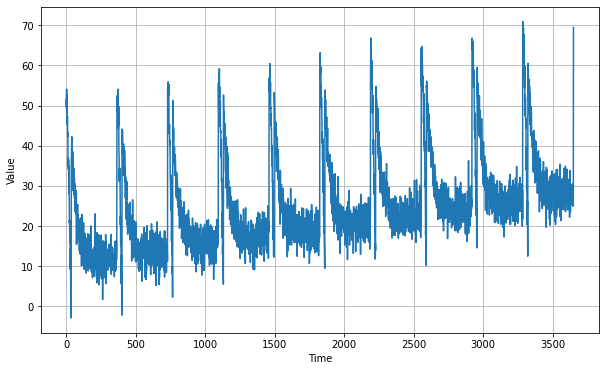

In [4]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# Splitting

In [5]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
len(time_train), len(time_valid)

(3000, 651)

In [7]:
len(x_train), len(x_valid)

(3000, 651)

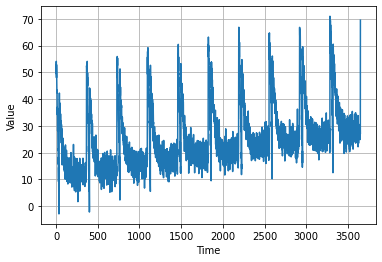

In [8]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_time_series(time, series)

# Windowed Dataset

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

for x,y in dataset:
  print(x.numpy(), y.numpy())
  break

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
[[11.736787  10.931049  12.769889   9.324754  13.369208  16.414112
  11.4943495 13.030507  13.900551  50.621338  52.448948  51.659607
  51.65394   48.675575  50.597443  51.444096  53.62815   51.377384
  54.086292  44.356533 ]
 [36.433025  37.549988  41.366707  42.251686  39.828697  38.26365
  37.02056   32.81843   34.44102   34.58124   38.51276   35.76576
  28.85418   34.53849   31.848099  30.42352   33.75375   34.489323
  33.680607  27.872099 ]
 [28.098782  34.991802  28.122038  27.156622  20.789549  21.500538
  21.501648  15.721646  18.283352  13.317255  12.193725   9.205523
  14.507013   6.8524427  1.6712772  5.277697  -2.8671904 -0.5677814
  36.433025  37.549988 ]
 [14.346582  11.298457  11.725901   8.780045  11.736787  10.931049
  12.769889   9.324754  13.369208  16.414112  11.4943495 13.030507
  13.900551  50.621338  52.448948  51.659607  51.65394   48.675575
  50.597443  51.444096 ]
 [10.740534  1

# Creating a Bidirectional LSTM Model

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*10.0)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
    metrics = ['mae'] 
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(dataset,
                    epochs=100,
                    callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 9s 30ms/step - loss: 26.8376 - mae: 27.3376
Epoch 2/100
94/94 [==============================] - 3s 29ms/step - loss: 26.7913 - mae: 27.2913
Epoch 3/100
94/94 [==============================] - 3s 28ms/step - loss: 26.7303 - mae: 27.2303
Epoch 4/100
94/94 [==============================] - 3s 29ms/step - loss: 26.6491 - mae: 27.1490
Epoch 5/100
94/94 [==============================] - 3s 29ms/step - loss: 26.5474 - mae: 27.0474
Epoch 6/100
94/94 [==============================] - 3s 29ms/step - loss: 26.4387 - mae: 26.9386
Epoch 7/100
94/94 [==============================] - 3s 30ms/step - loss: 26.3361 - mae: 26.8360
Epoch 8/100
94/94 [==============================] - 3s 28ms/step - loss: 26.2399 - mae: 26.7397
Epoch 9/100
94/94 [==============================] - 3s 29ms/step - loss: 26.1506 - mae: 26.6504
Epoch 10/100
94/94 [==============================] - 3s 28ms/step - loss: 26.0746 - mae: 26.5745
Epoch 11/100
94/94 [=========

(1e-08, 0.0001, 0.0, 30.0)

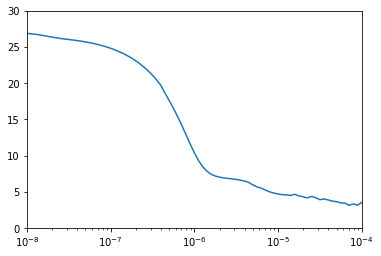

In [14]:
plt.semilogx(history.history['lr'],
             history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*10.0)
])


model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
    metrics = ['mae'] 
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(dataset,
                    epochs=500)

Epoch 1/500
94/94 [==============================] - 9s 28ms/step - loss: 18.5487 - mae: 19.0475
Epoch 2/500
94/94 [==============================] - 3s 30ms/step - loss: 7.2756 - mae: 7.7554
Epoch 3/500
94/94 [==============================] - 3s 28ms/step - loss: 6.8505 - mae: 7.3299
Epoch 4/500
94/94 [==============================] - 3s 28ms/step - loss: 6.6160 - mae: 7.0944
Epoch 5/500
94/94 [==============================] - 3s 29ms/step - loss: 6.1613 - mae: 6.6386
Epoch 6/500
94/94 [==============================] - 3s 28ms/step - loss: 5.6760 - mae: 6.1485
Epoch 7/500
94/94 [==============================] - 3s 28ms/step - loss: 5.3364 - mae: 5.8070
Epoch 8/500
94/94 [==============================] - 3s 29ms/step - loss: 5.0316 - mae: 5.5010
Epoch 9/500
94/94 [==============================] - 3s 28ms/step - loss: 4.8222 - mae: 5.2918
Epoch 10/500
94/94 [==============================] - 3s 28ms/step - loss: 4.7004 - mae: 5.1689
Epoch 11/500
94/94 [===========================

# Forecast

In [17]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

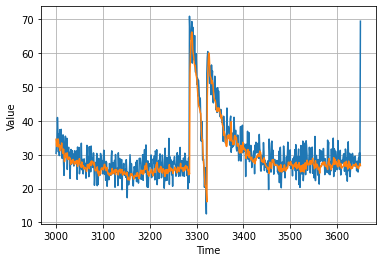

In [18]:
plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.0814078

# Plot

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

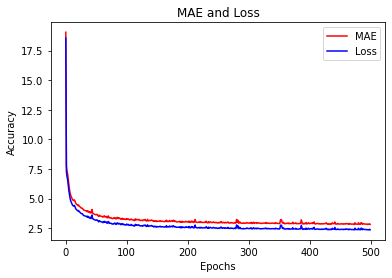

<Figure size 432x288 with 0 Axes>

In [21]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()


<Figure size 432x288 with 0 Axes>

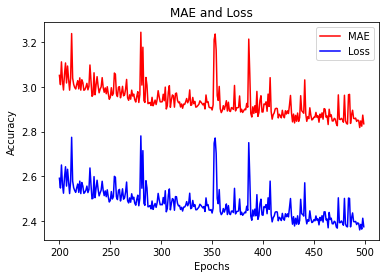

<Figure size 432x288 with 0 Axes>

In [22]:
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()